In [1]:
using JuMP, GLPK
using VoronoiCells, GeometryBasics, Plots
using Random
using Statistics
using Distributions
using StatsBase

In [236]:
function get_cost_matrix(x, y, norm=2)    
    m = size(x)[1]
    n = size(y)[1]
    #Calculo los costos Cij = |xi-yj| (distancia euclidea en R^2)
    c1 = (x[:,1]*ones(1,n) - ones(m,1)*y[:,1]').^norm
    c2 = (x[:,2]*ones(1,n) - ones(m,1)*y[:,2]').^norm
    return (c1+c2).^(1/norm)
end

function plot_locations(x, title)
    
    gr()
    Plots.GRBackend()
    
    m = size(x)[1]
    
    X = x[:,1]
    Y = x[:,2]
    
    scatter(X, Y, aspect_ratio=:equal, markersize = 3, xlim = (-0.1, 1.1), ylim = (-0.1, 1.1), title = title, legend = false)
    
end

function plot_stations(y, title)
   
    plot_locations(y, title)
    
    n = size(y)[1];
    
    points = [Point2(y[i,1], y[i,2]) for i in 1:n];
    
    scatter!(y[:,1], y[:,2], markersize = 6, label = "Stations", markershape = :star) # Plot Stations
    annotate!([(points[i][1] + 0.02, points[i][2] + 0.03, text(i, :black)) for i in 1:n]) # Add Station Number
    
end

function plot_assignments(x, y, Pi, voronoi = true)
    gr()
    Plots.GRBackend()

    # Define m and n
    m = size(x)[1]
    n = size(y)[1]

    # Create Stations List
    points = [Point2(y[i,1], y[i,2]) for i in 1:n] 

    # Voronoi Cells
    rect = Rectangle(Point2(0.0, 0.0), Point2(1.5, 1.5))
    tess = voronoicells(points, rect);
        
    if voronoi == true
        plot(tess, color = :green, alpha = 0.4)
    end

    #Assigments
    assigned_index = [argmax(Pi[i,:]) for i in 1:m];
    
    #Array of arrays. Each array is the amount of cars that go on a particular station
    X = [ x[findall(x->x==i, assigned_index),1] for i in 1:n];
    Y = [ x[findall(x->x==i, assigned_index),2] for i in 1:n];

    for i = 1:n
        scatter!(X[i], Y[i], aspect_ratio=:equal, markersize = 3, legend = false, labels = "Assigned to $i") # Plot EVs (differente color by each Station)
    end
        
    for i=1:m
        plot!([x[i,1],y[assigned_index[i],1]],[x[i,2],y[assigned_index[i],2]],color=:black, alpha = 0.2, labels = "") 
    end
    
    scatter!(y[:,1], y[:,2], markersize = 8, label = "Stations", markershape = :star, color=:white) # Plot Stations
    annotate!([(points[i][1] + 0.04, points[i][2] + 0.00, text(i, :black)) for i in 1:n]) # Add Station Number
end

function delete_row(matrix, row_index)
    
    return matrix[setdiff(1:end, row_index), :];
    
end

function random_points(size, dx, dy)
   
    rand_x = rand(dx, (size,1))
    rand_y = rand(dy, (size,1))
    
    random_point = hcat(rand_x, rand_y);
    
    return random_point;
    
end

function Geneterate_Ev_distribution(m, congestion_centers)
    
    #Random.seed!(40)

    x = [0 0]
    
    for congestion_point in congestion_centers
    
        mean_x = congestion_point[1];
        mean_y = congestion_point[2];
        variance_x = congestion_point[3];
        variance_y = congestion_point[4];
        amount_of_evs = m * (congestion_point[5] / 100);
        amount_of_evs = floor(amount_of_evs);
        amount_of_evs = Int(amount_of_evs);
        
        dx = Distributions.Normal(mean_x, variance_x)
        dy = Distributions.Normal(mean_y, variance_y)

        new_points = random_points(amount_of_evs, dx, dy)

        x = vcat(x, new_points)  

    end

    x = delete_row(x, 1);
    
    return sortslices(x, dims = 1);
    
end

function Solve_Model(C, s_max)
    
    m = size(C)[1];
    n = size(C)[2];
    
    q = ones(m,1);
   
    model = JuMP.Model(GLPK.Optimizer)
        
    @variable(model,Pi[1:m,1:n]>=0)
    
    p = sum(Pi, dims=2);
    s = sum(Pi, dims=1);

    @constraint(model, p .== q)
    @constraint(model, con, s .- s_max .<= zeros(1,n)) 

    @objective(model, Min, sum( C.*Pi ))

    optimize!(model)
    
    Pi = value.(Pi) 

    s = sum(Pi, dims = 1);
   
    mu = dual.(con)
    return s, abs.(mu), Pi;
    
end

function Print_Model(C, s_max)
    
    m = size(C)[1];
    n = size(C)[2];
    
    q = ones(m,1);
   
    model = JuMP.Model(GLPK.Optimizer)
        
    @variable(model,Pi[1:m,1:n]>=0)
    
    p = sum(Pi, dims=2);
    s = sum(Pi, dims=1);

    @constraint(model, p .== q)
    @constraint(model, con, s .- s_max .<= zeros(1,n)) 

    @objective(model, Min, sum( C.*Pi ))

    optimize!(model)   
    
    println(dual.(con))

    Pi = value.(Pi) 
    
    plot_assignments(x, y, Pi)

    
end

struct Arrival
    stations :: Vector{Float64}
    ArrivalTime::Float64
    ChargeTime::Float64
end

function get_charged_stations_indexes(arrivals, t)
    
    # Finds all indexes of rows that arrival time + charged time is greater than
    # actual time
    return findall(arrival -> t >= arrival.ArrivalTime + arrival.ChargeTime, arrivals)
end

function has_any_car_been_charged(s_charged_indexes)
    return size(s_charged_indexes)[1] > 0
end

function convert_vector_to_matrix(vector)
    return reduce(hcat,vector)';
end

function create_arrival(s, t, dist)
   charge_time = rand(dist)
   charge_time = round(charge_time, digits=1)
   return Arrival(s[1,:], t, charge_time)
end

function get_stations(arrivals)
    return map(arrival ->arrival.stations, arrivals)
end

function get_total_stations_assignment(arrivals)
    stations = get_stations(arrivals)
    stations_total = sum(stations, dims = 1)
    stations_total = convert_vector_to_matrix(stations_total)
    return stations_total
end

function probability_of_charged(t)
    a = 1/200
    p = 1 - exp(-a*t)
    return p
end

function has_car_charged(t)
    p = probability_of_charged(t)
    n = rand()
    return n < p  
end

function plot_per_station(time, stations_per_time)
    number_of_stations = length(stations_per_time[1])
    
    attribute_per_stations = []

    for station_number = 1:number_of_stations
        attribute_of_station = map(attribute -> attribute[station_number], stations_per_time)
        push!(attribute_per_stations, attribute_of_station)
    end

    plot(time, attribute_per_stations)
end

function remove_assigned_cars_from_x(x, Pi, amount_to_remove)
    
    n = size(Pi)[2]
    
    new_x = copy(x);
    
    total_cars_to_remove = sum(car_indexes_to_remove_station);
    
    total_indexes_to_remove = [];
    
    for station in 1:n
        
        assigned_car_indexes_station = findall(i -> i > 0.5, Pi[:, station])
        
        # If i want to remove more cars that are assigned, then the number of cars to remove
        # is the number of cars assigned
        if amount_to_remove[station] > length(assigned_car_indexes_station)
            amount_of_cars_to_remove =  length(assigned_car_indexes_station)
        else
            amount_of_cars_to_remove = amount_to_remove[station]
        end
          
        car_indexes_to_remove_station = sample(assigned_car_indexes_station, amount_of_cars_to_remove; replace=false)
        
        # Save indexes to remove later at once
        for index in car_indexes_to_remove_station
            push!(total_indexes_to_remove, index);
        end
                        
    end
    
    new_x = delete_row(new_x, total_indexes_to_remove)
    
    len = size(x)[1] - size(new_x)[1]
    # println("Cars removed: $len")
    
    return new_x;
    
end

remove_assigned_cars_from_x (generic function with 1 method)

# Evs location

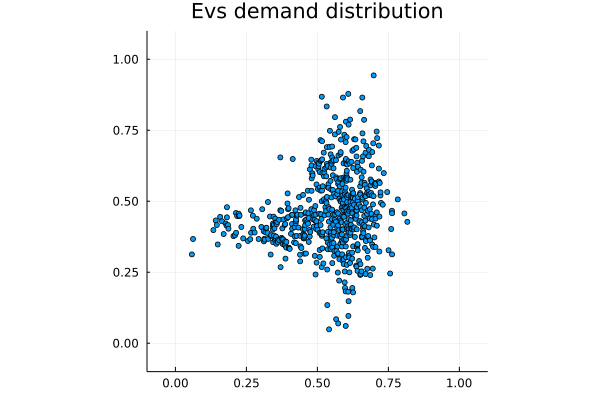

In [3]:
congestion_centers = [(0.6, 0.5, 0.08, 0.15, 70), (0.4, 0.4, 0.13, 0.05, 30)];

m = 600;

x = Geneterate_Ev_distribution(m, congestion_centers);

plot_locations(x, "Evs demand distribution")

# Stations locations

In [4]:
Random.seed!(23)

d = Distributions.Normal(0.5, 0.22)

n = 4;

y_stations = sortslices(rand(d, (n-1,2)), dims = 1);

far = [1.5 1.5]

y = [y_stations; far]

4×2 Matrix{Float64}:
 0.16379   0.287195
 0.196425  0.531954
 0.658969  0.699179
 1.5       1.5

# Dynamic functions

# Run Dynamic

[-0.9072223302453325 -0.881816010308371 -1.0319860892242079 0.0]


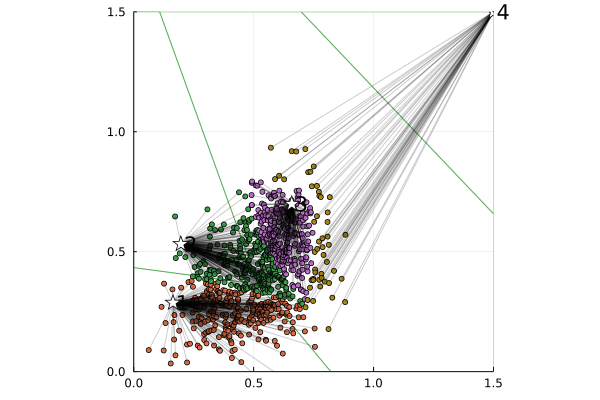

In [5]:
congestion_centers = [(0.6, 0.5, 0.1, 0.15, 65), (0.4, 0.3, 0.13, 0.12, 35)];

s_max = 250 * ones(1, n);

m = 800;
x = Geneterate_Ev_distribution(m, congestion_centers);
norm = 2;

C = get_cost_matrix(x, y, norm);

s = Print_Model(C, s_max)

In [6]:
max_capacity = 250;
free_charges = max_capacity * ones(1,n)
free_charges[n] = 500
free_charges

1×4 Matrix{Float64}:
 250.0  250.0  250.0  500.0

In [9]:
# Cars
m = 100;
congestion_centers = [(0.6, 0.5, 0.1, 0.15, 65), (0.4, 0.3, 0.13, 0.12, 35)];

# Time
t = 0;
k = 5;
dt = 1;
t_final = 200;

# Distributions
dist_arrivals = Poisson(50)
dist_charges = Poisson(50)

charge_time = 50;

# First arrival time
previous_arrival_time = t;
arrival_time = rand(dist_arrivals);

arrivals = Arrival[];

arrival_times = [];
occupations = [];
T = [];
mus = [];

# Stations max capacity
stations_capacity_ratios =  ones(1, n);

stations_capacity_ratios[1] = 0;
stations_capacity_ratios[n] = 2;

max_capacity = stations_capacity_ratios .* 250

free_charges = max_capacity;
busy_chargers = zeros(1,n);


while t <= t_final
    
    # arrival happened
    if t % k == 0
        
        # Departures
        i = 1;
        departures = zeros(1,n);
        for station in busy_chargers
            dist = Binomial(station, k / charge_time);
            departure = rand(dist);
            departures[i] = departure;
            i += 1
        end
                
        free_charges = free_charges + departures;
        busy_chargers = max_capacity .- free_charges;
        
        # println("t: $t | Departure $departures |  Busy chargers $busy_chargers");
        
        m = rand(dist_arrivals);
        m = floor(m);
                
        x = Geneterate_Ev_distribution(m, congestion_centers);
        C = get_cost_matrix(x, y, norm);
        
        s, mu, Pi = Solve_Model(C , free_charges);
        
        free_charges = free_charges - s;
        busy_chargers = max_capacity .- free_charges;
        
        push!(arrival_times, t)
        push!(mus,mu)
        
        # println("t: $t | Arrival $s | Busy chargers $busy_chargers");
                
    end
    
    occupation = max_capacity .- free_charges;
    push!(occupations, occupation)    
    push!(T,t);
    t = t + dt;
          
end

In [244]:
x = [0.5 0.5]
new_x = [0 0.5; 0.1 0.33]

x = [x;new_x]

3×2 Matrix{Float64}:
 0.5  0.5
 0.0  0.5
 0.1  0.33

In [230]:
amount_to_remove = [0 10 5 0];

println(size(x));

new_x = remove_assigned_cars_from_x(x, Pi, amount_to_remove)

println(size(new_x));

(64, 2)
Amount of cars to remove: 0
Amount of cars to remove: 10
Amount of cars to remove: 5
Amount of cars to remove: 0
Cars removed: 15
(49, 2)


In [264]:
# Cars
m = 100;
congestion_centers = [(0.6, 0.5, 0.1, 0.15, 65), (0.4, 0.3, 0.13, 0.12, 35)];

# Time
t = 0;
k = 5;
dt = 1;
t_final = 300;

# Distributions
dist_arrivals = Poisson(25)
charge_time = 40;

# First arrival time
previous_arrival_time = t;
arrival_time = rand(dist_arrivals);

arrivals = Arrival[];

arrival_times = [];
occupations = [];
T = [];
mus = [];

# Stations max capacity
stations_capacity_ratios =  ones(1, n);

stations_capacity_ratios[n] = 2;

max_capacity = stations_capacity_ratios .* 250

free_charges = max_capacity;
busy_chargers = zeros(1,n);

x = [0.5 0.5]

while t <= t_final
    # arrival happened
    if t % k == 0
        
        # Departures
        if t > k
            
            # Calculate number of vehicules to remove per station
            i = 1;
            departures = zeros(1,n);
            for station in busy_chargers
                dist = Binomial(station, k / charge_time);
                departure = rand(dist);
                departures[i] = departure;
                i += 1
            end
        
        
            x = remove_assigned_cars_from_x(x, Pi, amount_to_remove)
                
            busy_chargers = busy_chargers .- departures;
        
            println("t: $t | Departure $departures |  Busy chargers $busy_chargers");
        end
        
        m = rand(dist_arrivals);
        m = floor(m);
                
        new_x = Geneterate_Ev_distribution(m, congestion_centers);
        x = [x; new_x];
        C = get_cost_matrix(x, y, norm);
        
        s, mu, Pi = Solve_Model(C , max_capacity);
        
        busy_chargers = s;
        
        plot_assignments(x, y, Pi)
        savefig("images/assignments_$t.png")

        push!(arrival_times, t)
        push!(mus,mu)
        
        println("t: $t | Arrival amount $m | Busy chargers $busy_chargers");
                
    end
    
    occupation = busy_chargers;
    push!(occupations, occupation)    
    push!(T,t);
    t = t + dt;
          
end

t: 0 | Arrival amount 35 | Busy chargers [14.0 6.0 15.0 0.0]
t: 5 | Arrival amount 28 | Busy chargers [22.0 8.0 32.0 0.0]
t: 10 | Departure [3.0 0.0 7.0 0.0] |  Busy chargers [19.0 8.0 25.0 0.0]
t: 10 | Arrival amount 28 | Busy chargers [28.0 7.0 41.0 0.0]
t: 15 | Departure [3.0 2.0 6.0 0.0] |  Busy chargers [25.0 5.0 35.0 0.0]
t: 15 | Arrival amount 19 | Busy chargers [33.0 1.0 48.0 0.0]
t: 20 | Departure [3.0 0.0 2.0 0.0] |  Busy chargers [30.0 1.0 46.0 0.0]
t: 20 | Arrival amount 17 | Busy chargers [37.0 1.0 54.0 0.0]
t: 25 | Departure [3.0 0.0 7.0 0.0] |  Busy chargers [34.0 1.0 47.0 0.0]
t: 25 | Arrival amount 28 | Busy chargers [46.0 6.0 61.0 0.0]
t: 30 | Departure [5.0 1.0 8.0 0.0] |  Busy chargers [41.0 5.0 53.0 0.0]
t: 30 | Arrival amount 17 | Busy chargers [52.0 1.0 65.0 0.0]
t: 35 | Departure [11.0 0.0 8.0 0.0] |  Busy chargers [41.0 1.0 57.0 0.0]
t: 35 | Arrival amount 34 | Busy chargers [63.0 2.0 80.0 0.0]
t: 40 | Departure [6.0 0.0 13.0 0.0] |  Busy chargers [57.0 2.0 67.

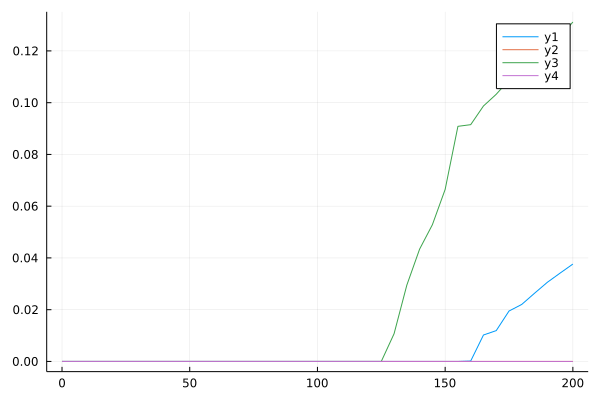

In [260]:
plot_per_station(arrival_times, mus)

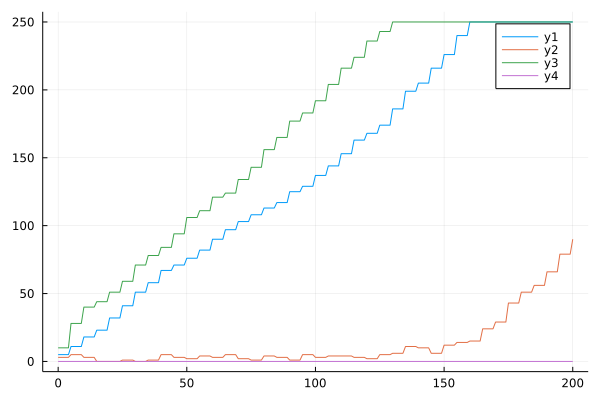

In [261]:
plot_per_station(T, occupations)